# PURPOSE
* The purpose of this notebook is to compare OLS regression to XGBoost fitted to non-linear data.  It is acknowledged that the models are only fit on training data since the point of this notebook is to look at metrics that indicate the models can learn from the data rather than test predictive ability or assess bias and variance.
* Brandon Johnson

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sympy as sym
from IPython.display import Math
from feature_engine.encoding import OneHotEncoder
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.metrics import r2_score, mean_squared_error

In [70]:
df = pd.read_csv('C:\\Users\\JB\\Desktop\\AMU\\COURSES\\Business Analytics Related Courses\\ANLY461 Applied Analytics II\\W7 Multiple Regression\\heart_failure_clinical_records_dataset.csv',)
df.sample(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
89,57.0,1,115,0,25,1,181000.0,1.1,144,1,0,79,0
177,49.0,1,69,0,50,0,132000.0,1.0,140,0,0,147,0
207,85.0,0,212,0,38,0,186000.0,0.9,136,1,0,187,0
218,68.0,1,1021,1,35,0,271000.0,1.1,134,1,0,197,0
247,64.0,0,143,0,25,0,246000.0,2.4,135,1,0,214,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### Selecting Variables

In [29]:
df.columns.to_list()

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time',
 'DEATH_EVENT']

In [37]:
cat_names = df.select_dtypes(int).drop(['DEATH_EVENT','creatinine_phosphokinase','serum_sodium','ejection_fraction','time'],axis=1).columns.to_list()
cat_names

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [41]:
df[['creatinine_phosphokinase','serum_sodium','ejection_fraction']] = df[['creatinine_phosphokinase','serum_sodium','ejection_fraction']].astype('float64')

In [44]:
num_names = df.select_dtypes(float).drop('platelets',axis=1).columns.to_list()
num_names

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'serum_creatinine',
 'serum_sodium']

**Partitioning Variables**

In [48]:
X = df[cat_names+num_names]
X.head()

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium
0,0,0,1,1,0,75.0,582.0,20.0,1.9,130.0
1,0,0,0,1,0,55.0,7861.0,38.0,1.1,136.0
2,0,0,0,1,1,65.0,146.0,20.0,1.3,129.0
3,1,0,0,1,0,50.0,111.0,20.0,1.9,137.0
4,1,1,0,0,0,65.0,160.0,20.0,2.7,116.0


In [49]:
y = df.platelets

In [58]:
y

0      265000.00
1      263358.03
2      162000.00
3      210000.00
4      327000.00
         ...    
294    155000.00
295    270000.00
296    742000.00
297    140000.00
298    395000.00
Name: platelets, Length: 299, dtype: float64

### EDA

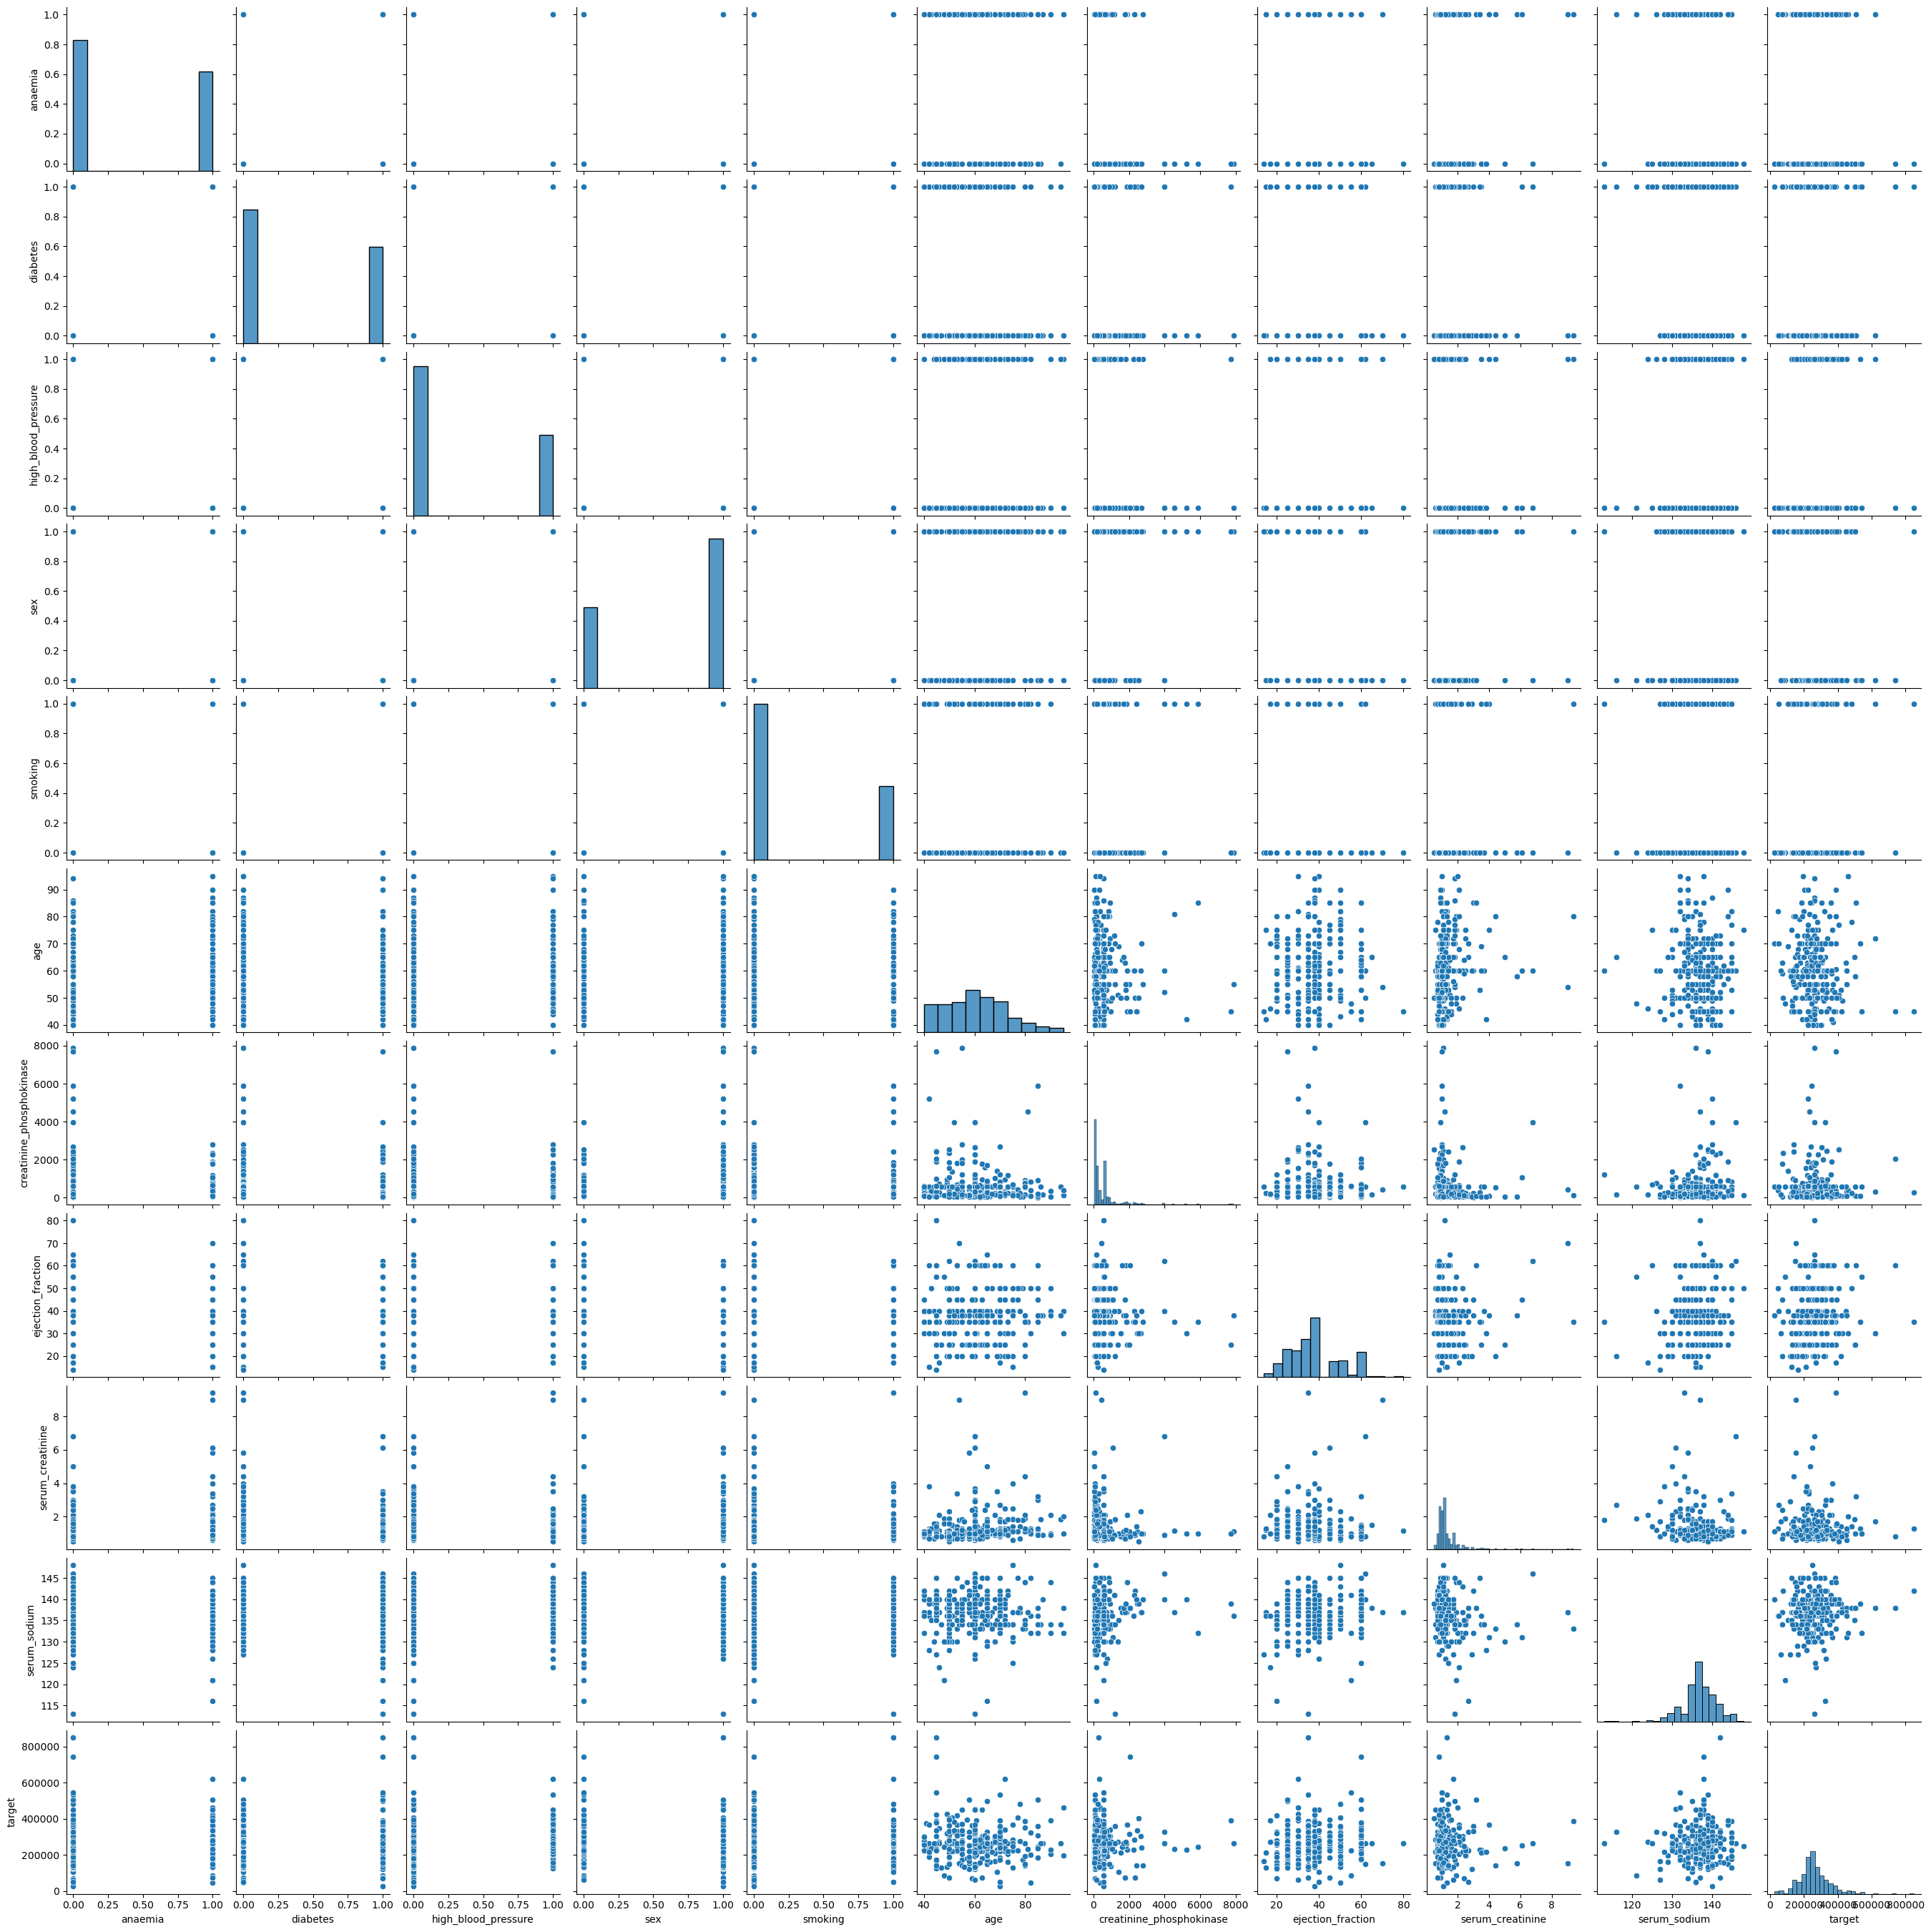

In [63]:
combined_df = pd.DataFrame(np.column_stack((X,y)), columns=X.columns.to_list()+['target'])

sns.pairplot(data=combined_df)

### Preprocessing

In [54]:
X_encoded = OneHotEncoder(drop_last=True,variables=cat_names,ignore_format=True).fit_transform(X)
X_encoded.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium,anaemia_0,diabetes_0,high_blood_pressure_1,sex_1,smoking_0
0,75.0,582.0,20.0,1.9,130.0,1,1,1,1,1
1,55.0,7861.0,38.0,1.1,136.0,1,1,0,1,1
2,65.0,146.0,20.0,1.3,129.0,1,1,0,1,0
3,50.0,111.0,20.0,1.9,137.0,0,1,0,1,1
4,65.0,160.0,20.0,2.7,116.0,0,0,0,0,1


### Linear Regression Modeling

In [56]:
model = sm.OLS(endog=y,exog=sm.add_constant(X_encoded)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              platelets   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.318
Date:                Sat, 18 Feb 2023   Prob (F-statistic):              0.220
Time:                        10:15:44   Log-Likelihood:                -3852.8
No. Observations:                 299   AIC:                             7728.
Df Residuals:                     288   BIC:                             7768.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     1.497e+05   1.85e+05      0.807      0.420   -2.15e+05    5.15e+05
age                       -267.3738    489.463     -0.546      0.585   -1230.751     696.004
creatinine_phosphokinase     2.8928      5.980      0.484      0.629      -8.878      14.663
ejection_fraction          430.4242    490.934      0.877      0.381    -535.850    1396.698
serum_creatinine         -1423.0656   5632.448     -0.253      0.801   -1.25e+04    9662.917
serum_sodium              1107.7468   1335.730      0.829      0.408   -1521.284    3736.777
anaemia_0                 8192.7199   1.17e+04      0.699      0.485   -1.49e+04    3.13e+04
diabetes_0               -1.694e+04   1.17e+04     -1.445      0.150      -4e+04    6133.380
high_blood_pressure_1     9171.6415   1.19e+04      0.768      0.443   -1.43e+04    3.27e+04
sex_1                    -3.081e+04   1.35e+04     -2.280      0.023   -5.74e+04   -4214.151
smoking_0                -2.288e+04   1.36e+04     -1.685      0.093   -4.96e+04    3852.068
==============================================================================
Omnibus:                      100.542   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.644
Skew:                           1.346   Prob(JB):                     7.61e-97
Kurtosis:                       8.318   Cond. No.                     3.73e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
rmse_ols = np.sqrt(np.sum(model.resid**2))
print(f'RMSE: {rmse_ols:,.3f}')

RMSE: 1,650,997.095


### XGBOOST MODEL

In [73]:
xgbr = XGBRegressor().fit(X,y)

y_preds = xgbr.predict(X)

redisuals = y - y_preds

In [74]:
r2 = r2_score(y,y_preds)
print(f'R2: {r2:.3f}')

rmse = mean_squared_error(y,y_preds, squared=False)
print(f'RMSE: {rmse:.3f}')

R2: 1.000
RMSE: 836.275


In [75]:
y.std()

97804.23686859828

### COMPARISON

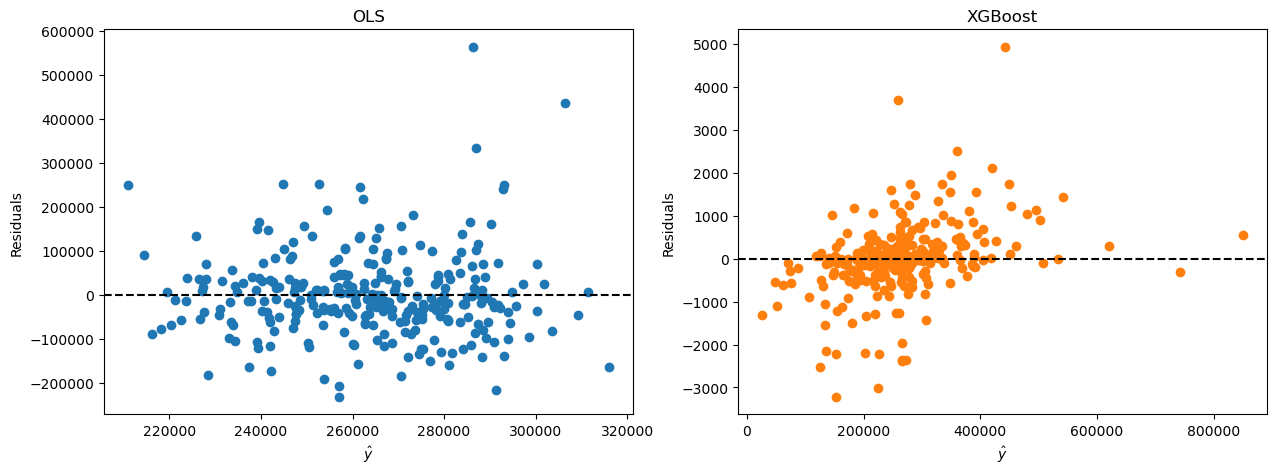

In [92]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

r2s = [0.044, 1.0]
rmses = [rmse_ols,rmse]
resids = [model.resid,redisuals]
preds = [model.predict(),y_preds]
titles = ['OLS','XGBoost']
colors = ['tab:blue','tab:orange']

for i,ax in enumerate(axs.flatten()):
    ax.scatter(preds[i],resids[i],c=colors[i])
    ax.axhline(0,c='k',ls='--')
    ax.set_title(titles[i])
    ax.set_ylabel('Residuals')
    ax.set_xlabel('$\\hat{y}$')

plt.show()
    

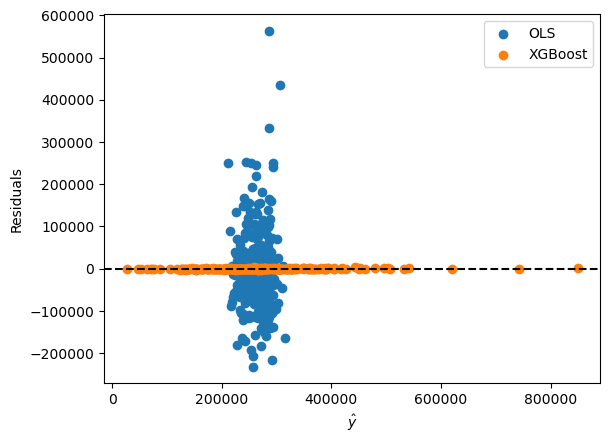

In [83]:
for i in range(len(r2s)):
    plt.scatter(preds[i],resids[i],label=titles[i])

plt.axhline(0,c='k',ls='--')
plt.legend()
plt.xlabel('$\\hat{y}$')
plt.ylabel('Residuals')
plt.show()